In [43]:
import numpy as np
import qiskit
import mitiq
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

In [44]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [45]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

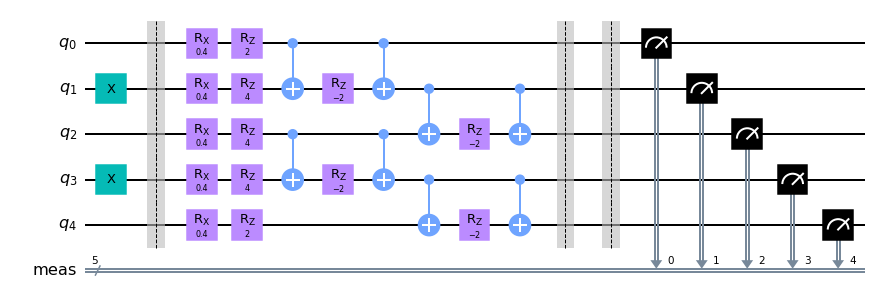

In [46]:
#See if the Trotter cirucit is correctly being built. Change x in Trotter_circuit[x] to see the cirucit
# for different time slices.
Trotter_circuit[1].draw(output='mpl')

In [47]:
#This cell sets up everythin we need so the readout error mitigation will work.
from qiskit.test.mock import FakeVigo

backend = FakeVigo()

#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(5)

noise_model = NoiseModel.from_backend(backend)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
cal_results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [48]:
#define the executor so mitiq will work. Note that the noise model is contained within here,
# so every time it is called, the result will be noisy.
def qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns <Z>, aka the expectation value of Z for the particular qubit that
    was input."""
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    prob = 0
    for x in counts.keys():
        if x[qubit] == '1':
            prob += counts[x] / shots
    return 2*prob - 1

In [49]:
qiskit_multiqubit_executor(Trotter_circuit[1],8192,0)

-0.8985015694364052

In [50]:
from functools import partial

scale_factors = [1., 2., 3.]

linear_factory = mitiq.zne.inference.LinearFactory(scale_factors)

def zne_expval(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp,factory = linear_factory, num_to_average = 3)

In [51]:
zne_expval(8192, 0, 1)

-0.9129220423287654

In [52]:
def ideal_qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns <Z>, aka the expectation value of Z for the particular qubit that
    was input."""
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    #noise_model = NoiseModel.from_backend(backend)
    
    #basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        Aer.get_backend('qasm_simulator'),
        #basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    prob = 0
    for x in counts.keys():
        if x[qubit] == '1':
            prob += counts[x] / shots
    return 2*prob - 1

In [53]:
ideal_qiskit_multiqubit_executor(Trotter_circuit[1], 8192, 0)

-0.9762207085481516

In [66]:
from mitiq.pec import represent_operation_with_global_depolarizing_noise

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        #Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

Trotter_circuit[1].draw('mpl')

rep = represent_operation_with_global_depolarizing_noise(ideal_operation = Trotter_circuit[1],
                                                         noise_level = 0.01)


ValueError: Can only represent single- and two-qubit gates.Consider pre-compiling your circuit.

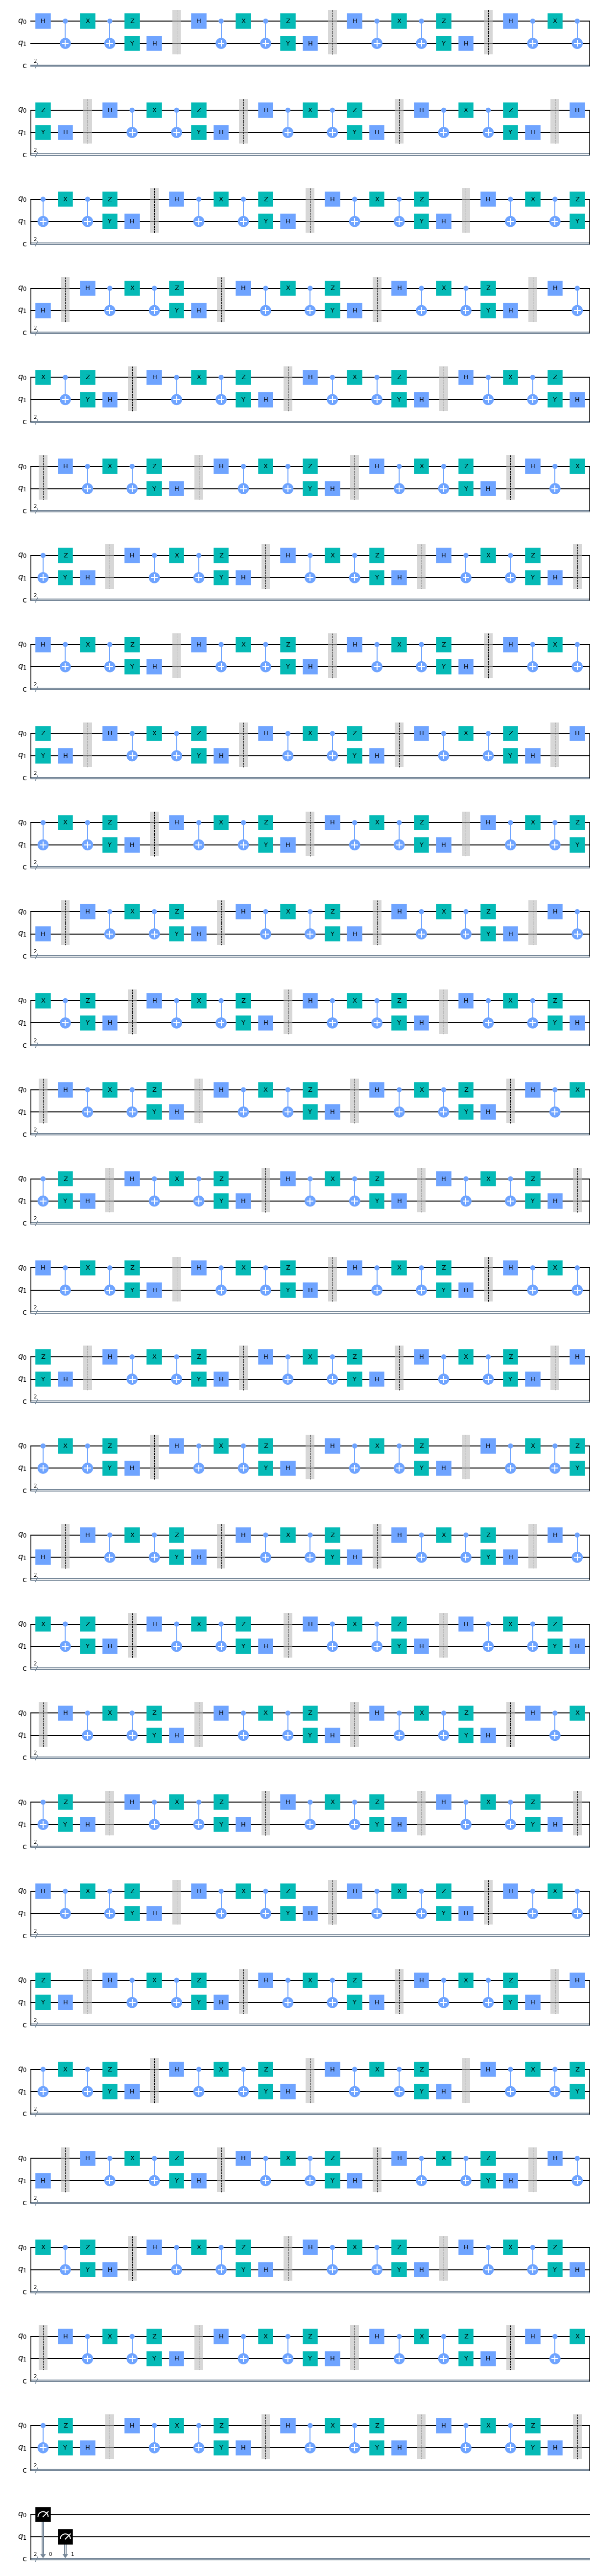

In [65]:
backend = qiskit.Aer.get_backend("qasm_simulator")

circuit = QuantumCircuit(2,2)

for temp in range(100):
    circuit.h(0)
    circuit.cx(0,1)
    circuit.x(0)
    circuit.cx(0,1)
    circuit.z(0)
    circuit.y(1)
    circuit.h(1)
    circuit.barrier()

circuit.measure(0,0)
circuit.measure(1,1)

job = qiskit.execute(circuit,backend,shots=4096)
results = job.result()
counts = results.get_counts()

circuit.draw(output='mpl')

In [64]:
from mitiq import *

ideal_operation = Trotter_circuit[1]
noisy_basis = noise_model.basis_gates

mitiq.pec.representations.optimal.find_optimal_representation(ideal_operation, 
                                                              noisy_basis, tol=1e-08, initial_guess=None)

AttributeError: module 'mitiq.pec.representations' has no attribute 'optimal'

In [ ]:
from mitiq import pec

partial_executor = partial(qiskit_multiqubit_executor, shots = 8192, qubit = 0)

pec.execute_with_pec(Trotter_circuit[1],partial_executor,rep)
